In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
import numpy as np
%matplotlib inline
%load_ext rpy2.ipython

* ##Install the following packages in `R`, if not already installed:


    install.packages("ggplot2")
    install.packages("car")
    install.packages("agricolae")
    install.packages("lmtest")

* ##Test for interaction between *Site_Type* and *Treatment*, with *Sites* nested within *Site_Type* as an error term

In [2]:
df = pd.read_excel(r'MeiofaunaDZ.xlsx', 1)
df.columns = ['Weeks','Sites','Treatment','Rep','Meiofauna']
df['Site_Type'] = 'Die_off'
df.ix[df.Sites=='COM', 'Site_Type'] = 'Healthy'
df.ix[df.Sites=='HER', 'Site_Type'] = 'Healthy'
df['Sites_Trt'] = df.Sites + "_" + df.Treatment
df[['Sites',
    'Site_Type',
    'Sites_Trt',
    'Treatment',
    'Rep',
    'Meiofauna']].to_csv('0_sites.csv', index=None)
df.head()

,Weeks,Sites,Treatment,Rep,Meiofauna,Site_Type,Sites_Trt
0,8,COL,Cg,1,141.843180,Die_off,COL_Cg
1,8,COL,Cg,2,148.819074,Die_off,COL_Cg
2,8,COL,Cg,3,183.698545,Die_off,COL_Cg
3,8,COL,Cg,4,139.517882,Die_off,COL_Cg
4,8,COL,Cg,5,120.915498,Die_off,COL_Cg


* ##The first set of 4 plots are diagnostic plots for this model.
* ##The second plot (Box-Cox plot) indicates the optimial $\lambda$ is about 0.5, either $log$ transformation, or non-transformation will be apporiate.

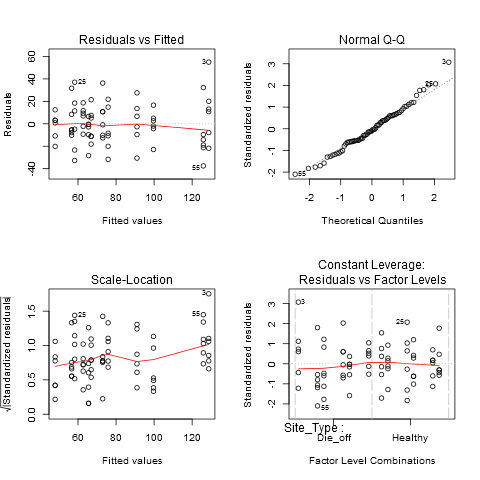

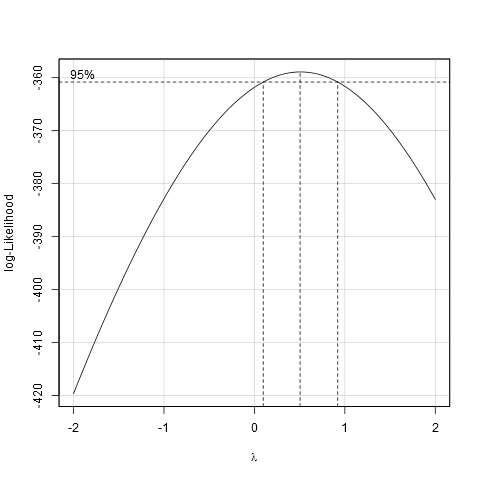

In [3]:
%%R
df <- read.csv('0_sites.csv')
df <- within(df, RepF <- factor(Rep))
df <- within(df, SitesF <- factor(Sites))
library(lattice)
library(car)
library(lmtest)
m1 <- aov(Meiofauna ~ Site_Type * Treatment + Error(SitesF%in%Site_Type), data = df)
s1 <- summary(m1)
m2 <- aov(Meiofauna ~ Site_Type * Treatment + SitesF%in%Site_Type, data = df)
par(mfrow=c(2,2))
plot(m2)
par(mfrow=c(1,1))
boxCox(m2)
s2 <- summary(m2)
bp <- bptest(m2)
pt <- with(df, pairwise.t.test(Meiofauna, Sites_Trt, p.adjust.method='holm', paired=T))

* ##*Sites* is modelled as an error term nested in *Site_Type*
* ##*Site_Type* effect is non-significant, $F_{1,2}=16.56$
* ##*Treatment* effect is significant, $F_{2,64}=52.87$
* ##Interaction effect is non-significant, $F_{2,64}=2.256$

In [4]:
print ro.r.s1


Error: SitesF:Site_Type
          Df Sum Sq Mean Sq F value Pr(>F)  
Site_Type  1   6186    6186   16.56 0.0554 .
Residuals  2    747     373                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                    Df Sum Sq Mean Sq F value   Pr(>F)    
Treatment            2  38067   19034  52.873 2.78e-14 ***
Site_Type:Treatment  2   1625     812   2.256    0.113    
Residuals           64  23039     360                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



* ##There is no indication that the homoscedasticity assumption is voilated.

In [5]:
print ro.r.bp


	studentized Breusch-Pagan test

data:  m2
BP = 10.45, df = 11, p-value = 0.4904




* ##Pairwise `t test` with Holm's correction for multiple test.
  Holm, S. (1979). A simple sequentially rejective multiple test procedure. Scandinavian Journal of Statistics 6, 65–70. 

In [6]:
print ro.r.pt


	Pairwise comparisons using paired t tests 

data:  Meiofauna and Sites_Trt 

        COL_Cg COL_Con COL_Pc COM_Cg COM_Con COM_Pc HER_Cg HER_Con HER_Pc
COL_Con 0.030  -       -      -      -       -      -      -       -     
COL_Pc  0.049  1.000   -      -      -       -      -      -       -     
COM_Cg  1.000  1.000   0.529  -      -       -      -      -       -     
COM_Con 0.052  1.000   1.000  1.000  -       -      -      -       -     
COM_Pc  0.019  1.000   1.000  0.316  1.000   -      -      -       -     
HER_Cg  0.862  1.000   0.224  1.000  0.326   0.008  -      -       -     
HER_Con 0.087  1.000   1.000  1.000  1.000   1.000  0.752  -       -     
HER_Pc  0.016  1.000   1.000  0.732  1.000   1.000  0.161  1.000   -     
SAQ_Cg  1.000  1.000   0.062  1.000  0.788   0.087  1.000  0.787   0.087 
SAQ_Con 0.088  1.000   1.000  1.000  1.000   0.977  1.000  1.000   1.000 
SAQ_Pc  0.206  1.000   1.000  1.000  1.000   0.340  0.107  1.000   1.000 
        SAQ_Cg SAQ_Con
COL_Con - 

* #The 'swtich' experiment

In [7]:
df = pd.read_excel('MeiofaunaDZ.xlsx', 2)
df.columns = ['Sample', 'Weeks','Sites','Treatment','Rep','Meiofauna']
df['Sites_Trt'] = df.Sites + "_" + df.Treatment
df['log_Meio']  = np.log(df.Meiofauna)
df['BC_Meio'] = (np.power(df.Meiofauna, 0.089)-1)/0.089
df[['Sites',
    'Sites_Trt',
    'Treatment',    
    'Rep',
    'Meiofauna',
    'log_Meio',
    'BC_Meio']].to_csv('1_sites.csv', index=None)
df.head()

,Sample,Weeks,Sites,Treatment,Rep,Meiofauna,Sites_Trt,log_Meio,BC_Meio
0,8HC1,8,HER,C,1,15.695754,HER_C,2.753390,3.120083
1,8HC2,8,HER,C,2,36.623425,HER_C,3.600688,4.244529
2,8HC3,8,HER,C,3,15.695754,HER_C,2.753390,3.120083
3,8HC4,8,HER,C,4,39.239384,HER_C,3.669681,4.339877
4,8HC5,8,HER,C,5,49.703219,HER_C,3.906070,4.671043


* ##The first set of 4 plots are diagnostic plots for this model.
* ##The second plot (Box-Cox plot) indicates the optimial $\lambda$ is about 0.0, suggestion a $log$ transformation.
* ##There are some indication of heavy tail in the `Q-Q plot`

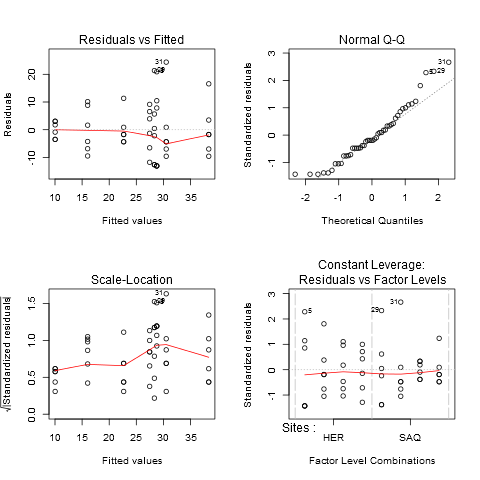

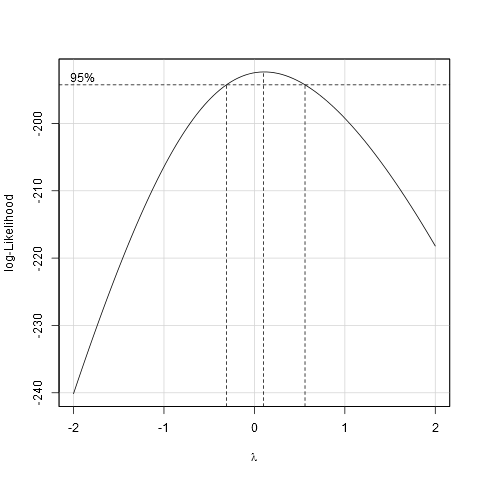

In [8]:
%%R
df <- read.csv('1_sites.csv')
df <- within(df, RepF <- factor(Rep))
df <- within(df, SitesF <- factor(Sites))
library(lattice)
library(car)
library(lmtest)
m1 <- aov(Meiofauna ~ Sites * Treatment, data = df)
s1 <- summary(m1)
m2 <- lm(Meiofauna ~ Sites * Treatment, data = df)
s2 <- summary(m2)
bp <- bptest(m2)
par(mfrow=c(2,2))
plot(m2)
par(mfrow=c(1,1))
boxCox(m2)
pt <- with(df, pairwise.t.test(Meiofauna, Sites_Trt, p.adjust.method='holm', paired=T))

* ##Improved model

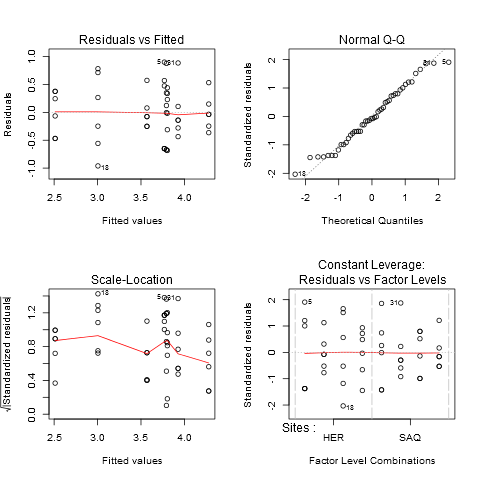

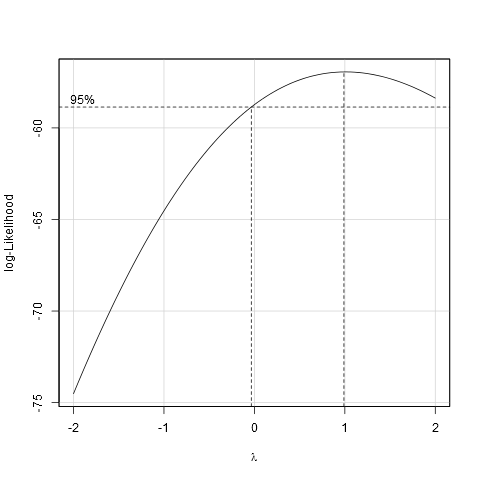

In [9]:
%%R
m1 <- aov(BC_Meio ~ Sites * Treatment, data = df)
s1 <- summary(m1)
m2 <- lm(BC_Meio ~ Sites * Treatment, data = df)
s2 <- summary(m2)
bp <- bptest(m2)
par(mfrow=c(2,2))
plot(m2)
par(mfrow=c(1,1))
boxCox(m2)
pt <- with(df, pairwise.t.test(BC_Meio, Sites_Trt, p.adjust.method='holm', paired=T))

* ##*Site_Type* effect is marginally significant, $F_{1,40}=3.126$
* ##*Treatment* effect is significant, $F_{3,40}=1.13\cdot10^{-6}$
* ##Interaction effect is non-significant, $F_{3,60}=0.6599$

In [10]:
print ro.r.s1

                Df Sum Sq Mean Sq F value   Pr(>F)    
Sites            1  0.838   0.838   3.126   0.0847 .  
Treatment        3 12.015   4.005  14.939 1.13e-06 ***
Sites:Treatment  3  0.432   0.144   0.537   0.6599    
Residuals       40 10.724   0.268                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



* ##There is marginal indication that the homoscedasticity assumption is voilated.
* ##It is up to you to decide if you want to use the *Box-Cox* transformation apporach, or nonparametric alternative

In [11]:
print ro.r.bp


	studentized Breusch-Pagan test

data:  m2
BP = 14.485, df = 7, p-value = 0.0432




* ##If you use *Friedman rank sum test*, you will: 1, have to take group means and lose the repeat measures. 2, only be able to conclude *Sites* and *Treatment* have some effect but without know how much.
* ##I prefer the *Box-Cox* transformation apporach.

In [12]:
%%R
gpb_df  <- aggregate(df$Meiofauna,
                     by = list(Sites = df$Sites,
                               Trtmt = df$Treatment),
                     FUN = mean)
f1 <- friedman.test(x ~ Sites | Trtmt, data = gpb_df)

In [13]:
print ro.r.f1


	Friedman rank sum test

data:  x and Sites and Trtmt
Friedman chi-squared = 4, df = 1, p-value = 0.0455




* ##Pairwise `t test` with Holm's correction for multiple test.
  Holm, S. (1979). A simple sequentially rejective multiple test procedure. Scandinavian Journal of Statistics 6, 65–70. 

In [14]:
print ro.r.pt


	Pairwise comparisons using paired t tests 

data:  BC_Meio and Sites_Trt 

       HER_C HER_D HER_H HER_Pc SAQ_C SAQ_D SAQ_H
HER_D  1.000 -     -     -      -     -     -    
HER_H  0.038 0.185 -     -      -     -     -    
HER_Pc 1.000 1.000 1.000 -      -     -     -    
SAQ_C  1.000 1.000 0.325 1.000  -     -     -    
SAQ_D  1.000 0.966 1.000 1.000  1.000 -     -    
SAQ_H  0.105 0.012 0.966 0.105  0.105 0.165 -    
SAQ_Pc 1.000 0.396 1.000 1.000  1.000 1.000 0.038

P value adjustment method: holm 



* ##All done in `R` 3.2.1
* ###Citation: 
   R Development Core Team (2008). R: A language and environment forstatistical computing. R Foundation for Statistical Computing,Vienna, Austria. ISBN 3-900051-07-0, URL http://www.R-project.org.
* ###CT Zhu, ctzhu@brown.edu, 07-15-2015